<center> 

# EN3160 Assignment 3
## Neural Networks

### Priyankan V. - 210498T
</center>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# Check the GPU device if CUDA is available
if cuda_available:
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA-enabled GPU detected.")

# Check if PyTorch is using GPU
current_device = "GPU" if torch.cuda.current_device() else "CPU"
print(f"PyTorch is currently using: {current_device}")

CUDA available: False
No CUDA-enabled GPU detected.


RuntimeError: No CUDA GPUs are available

In [3]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

RuntimeError: invalid argument to reset_peak_memory_stats

Question 1

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32 #50

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
Din = 3*32*32 # Input size (flattened CIFAR=10 image size)
K = 10 # Output size (number of classes in CIFAR=10)
std = 1e-5
# Initialize weights and biases
w = torch.randn(Din, K, device=device, dtype=torch.float, requires_grad=True) * std
b = torch.randn(K, device=device, dtype=torch.float, requires_grad=True)
# Hyperparameters
iterations = 20
lr = 2e-6 # Learning rate
lr_decay = 0.9 # Learning rate decay
reg = 0 # Regularization
loss_history = [ ]

In [6]:
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1).to(device)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float().to(device)  # Convert labels to one-hot

        # Forward pass
        y_pred = x_train.mm(w) + b  # Output layer activation

        # Loss calculation (Mean Squared Error with regularization)
        loss = (1/Ntr) * torch.sum((y_pred - y_train_onehot) ** 2) + reg * torch.sum(w ** 2)
        running_loss += loss.item()

        # Backpropagation
        dy_pred = (2.0 / Ntr) * (y_pred - y_train_onehot)
        dw = x_train.t().mm(dy_pred) + reg * w
        db = dy_pred.sum(dim=0)

        # Parameter update
        w = w - lr * dw
        b = b - lr * db

    loss_history.append(running_loss / len(trainloader))
    print(f"Epoch {t + 1} / {iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1 / 20, Loss: 6.353109206591976
Epoch 2 / 20, Loss: 5.63223499330434
Epoch 3 / 20, Loss: 5.3202511146140266
Epoch 4 / 20, Loss: 5.143604679437151
Epoch 5 / 20, Loss: 5.023906750016996
Epoch 6 / 20, Loss: 4.934689746479613
Epoch 7 / 20, Loss: 4.864498894411406
Epoch 8 / 20, Loss: 4.806907325697036
Epoch 9 / 20, Loss: 4.758457398917991
Epoch 10 / 20, Loss: 4.718110105889163
Epoch 11 / 20, Loss: 4.683880163322102
Epoch 12 / 20, Loss: 4.652979651095389
Epoch 13 / 20, Loss: 4.627151500850783
Epoch 14 / 20, Loss: 4.60362073678049
Epoch 15 / 20, Loss: 4.584079537114041
Epoch 16 / 20, Loss: 4.56677646356291
Epoch 17 / 20, Loss: 4.550658755933941
Epoch 18 / 20, Loss: 4.537069770363913
Epoch 19 / 20, Loss: 4.5250799637609616
Epoch 20 / 20, Loss: 4.513954232002937


In [15]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

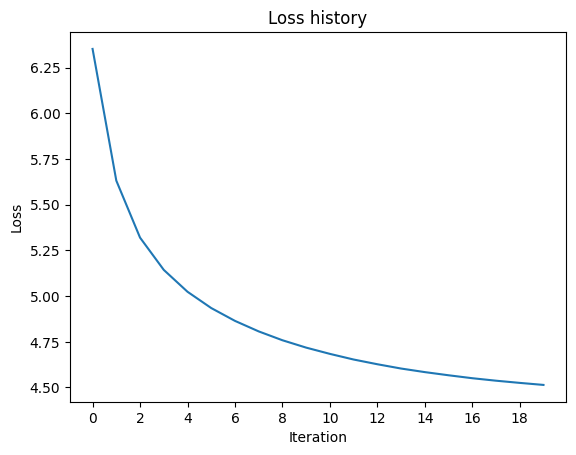

In [7]:
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.show()

In [8]:
def calculate_accuracy(dataloader: torch.utils.data.DataLoader, w: torch.Tensor, b: torch.Tensor) -> float:
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            N = inputs.shape[0]
            x = inputs.view(N, -1)
            y = x.mm(w) + b
            predicted = torch.argmax(y, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [9]:
train_accuracy = calculate_accuracy(trainloader, w, b)
test_accuracy = calculate_accuracy(testloader, w, b)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 12.06%
Test accuracy: 12.03%


(a) Adding a middle layer with 100 nodes and a sigmoid activation

In [10]:
del w, b, x_train, y_train_onehot, y_pred, loss, dy_pred, dw, db
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [11]:
# This implementation is not efficient and is only for educational purposes. For real-world applications, use PyTorch's built-in functions and classes. ThiS may fail
# as memory usage increases with the number of iterations.

Din = 3*32*32 # Input size (flattened CIFAR=10 image size)
K = 10 # Output size (number of classes in CIFAR=10)
std = 1e-5
# Initialize weights and biases
w1 = torch.randn(Din, 100, device=device, requires_grad=True)
b1 = torch.zeros(100, device=device, requires_grad=True)
w2 = torch.randn(100, K, device=device, requires_grad=True)
b2 = torch.zeros(K, device=device, requires_grad=True)
# Hyperparameters
iterations = 10 # Reduced as memory usage increases
lr = 2e-6 # Learning rate
lr_decay = 0.9 # Learning rate decay
reg = 0 # Regularization
loss_history = [ ]

In [12]:
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1).to(device)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float().to(device)  # One-hot labels

        # Forward pass
        hidden = x_train.mm(w1) + b1
        hidden_activation = torch.sigmoid(hidden)  # Sigmoid activation
        logits = hidden_activation.mm(w2) + b2  # Logits before softmax

        # Compute softmax probabilities
        max_logits = torch.max(logits, dim=1, keepdim=True)[0]
        exp_logits = torch.exp(logits - max_logits)
        probs = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)

        # Cross-Entropy Loss with L2 regularization
        epsilon = 1e-12  # Small value to prevent log(0)
        log_probs = torch.log(probs + epsilon)
        loss = -torch.sum(y_train_onehot * log_probs) / Ntr
        loss += reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))
        running_loss += loss.item()

        # Backpropagation
        dlogits = (probs - y_train_onehot) / Ntr 

        # Gradients for parameters of the second layer
        dw2 = hidden_activation.t().mm(dlogits) + reg * w2
        db2 = dlogits.sum(dim=0)

        # Backpropagate through ReLU activation
        dhidden_activation = dlogits.mm(w2.t())
        dhidden = dhidden_activation * hidden_activation * (1 - hidden_activation)  # Derivative of sigmoid

        # Gradients for parameters of the first layer
        dw1 = x_train.t().mm(dhidden) + reg * w1
        db1 = dhidden.sum(dim=0)

        # Parameter updates
        w2 = w2 - lr * dw2
        b2 = b2 - lr * db2
        w1 = w1 - lr * dw1
        b1 = b1 - lr * db1

    loss_history.append(running_loss / len(trainloader))
    print(f"Epoch {t+1} / {iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1 / 10, Loss: 10.10438054292841
Epoch 2 / 10, Loss: 10.08905182171539
Epoch 3 / 10, Loss: 10.073465087668527
Epoch 4 / 10, Loss: 10.061435923390258
Epoch 5 / 10, Loss: 10.049335336349595
Epoch 6 / 10, Loss: 10.039499758148681
Epoch 7 / 10, Loss: 10.030575141491832
Epoch 8 / 10, Loss: 10.021814475971693
Epoch 9 / 10, Loss: 10.015193915717965
Epoch 10 / 10, Loss: 10.008422162390945


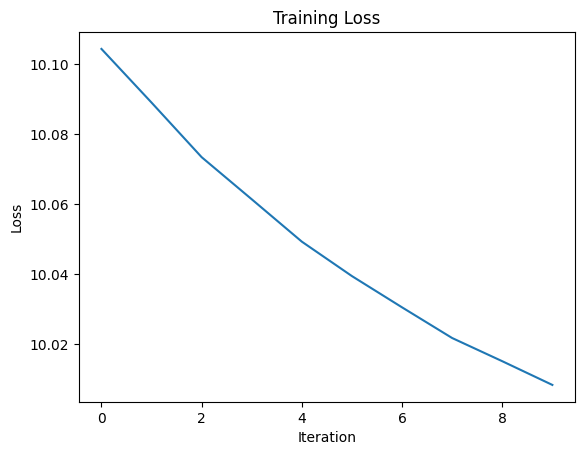

In [13]:
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.xticks(range(0, iterations, 2))
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [14]:
def calculate_accuracy(dataloader: torch.utils.data.DataLoader, w1: torch.Tensor, b1: torch.Tensor, w2: torch.Tensor, b2: torch.Tensor) -> float:
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            N = inputs.shape[0]
            x = inputs.view(N, -1)
            hidden = torch.sigmoid(x.mm(w1) + b1)
            y = hidden.mm(w2) + b2
            predicted = torch.argmax(y, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [15]:
train_accuracy = calculate_accuracy(trainloader, w1, b1, w2, b2)
test_accuracy = calculate_accuracy(testloader, w1, b1, w2, b2)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 8.19%
Test accuracy: 8.32%


In [16]:
Din = 3*32*32 # Input size (flattened CIFAR=10 image size)
K = 10 # Output size (number of classes in CIFAR=10)
lr = 1e-3 # Learning rate
reg = 1e-5 # Regularization strength

In [17]:
class NeuralNetwork(nn.Module):
    def __init__(self, Din, H, Dout):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(Din, H)
        self.linear2 = nn.Linear(H, Dout)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)
        return x

In [18]:
def train(model:nn.Module,
          trainloader:torch.utils.data.DataLoader,
          testloader:torch.utils.data.DataLoader,
          iterations:int,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          device: torch.device) -> tuple:
    train_accuracy_hist = [ ]
    test_accuracy_hist = [ ]
    train_loss_hist = [ ]
    test_loss_hist = [ ]
    for t in range(iterations):
        model.train()
        accuracy = 0
        running_loss = 0.0
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            x_train, y_train = inputs.to(device), labels.to(device)
            y_pred = model(x_train)
            loss_val = loss_fn(y_pred, y_train)
            running_loss += loss_val.item()
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            _, predicted = torch.max(y_pred, 1)
            accuracy += (predicted == y_train).sum().item()
        train_accuracy_hist.append(accuracy / len(trainloader.dataset))
        train_loss_hist.append(running_loss / len(trainloader))
        model.eval()
        with torch.inference_mode():
            accuracy = 0
            running_loss = 0.0
            for i, data in enumerate(testloader, 0):
                inputs, labels = data
                x_test, y_test = inputs.to(device), labels.to(device)
                y_pred = model(x_test)
                loss_val = loss_fn(y_pred, y_test)
                running_loss += loss_val.item()
                _, predicted = torch.max(y_pred, 1)
                accuracy += (predicted == y_test).sum().item()
            test_accuracy_hist.append(accuracy / len(testloader.dataset))
            test_loss_hist.append(running_loss / len(testloader))
        print(f"Epoch {t + 1} / {iterations}, Train Loss: {train_loss_hist[-1]}, Test Loss: {test_loss_hist[-1]}, Train Accuracy: {train_accuracy_hist[-1]}, Test Accuracy: {test_accuracy_hist[-1]}")
    return train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist

In [19]:
model = NeuralNetwork(Din, 100, K).to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
iterations = 20

In [20]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(model, trainloader, testloader, iterations, optimizer, loss, device)

Epoch 1 / 20, Train Loss: 1.753928979314144, Test Loss: 1.6641798167944717, Train Accuracy: 0.3891, Test Accuracy: 0.418
Epoch 2 / 20, Train Loss: 1.6293403200056793, Test Loss: 1.6396305496319414, Train Accuracy: 0.43462, Test Accuracy: 0.43
Epoch 3 / 20, Train Loss: 1.5761752811976144, Test Loss: 1.6081494847044777, Train Accuracy: 0.45456, Test Accuracy: 0.4456
Epoch 4 / 20, Train Loss: 1.5314262675994952, Test Loss: 1.5997292325138666, Train Accuracy: 0.4708, Test Accuracy: 0.4437
Epoch 5 / 20, Train Loss: 1.4938596631194716, Test Loss: 1.57586186800521, Train Accuracy: 0.48378, Test Accuracy: 0.4568
Epoch 6 / 20, Train Loss: 1.4612597240825074, Test Loss: 1.5687758781658574, Train Accuracy: 0.49384, Test Accuracy: 0.46
Epoch 7 / 20, Train Loss: 1.4309112773975805, Test Loss: 1.5631339649042002, Train Accuracy: 0.50492, Test Accuracy: 0.4634
Epoch 8 / 20, Train Loss: 1.4050408859551906, Test Loss: 1.5540164781454653, Train Accuracy: 0.51454, Test Accuracy: 0.4692
Epoch 9 / 20, Trai

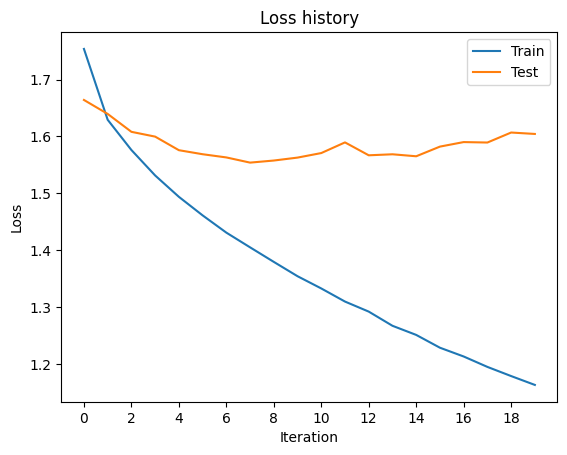

In [21]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

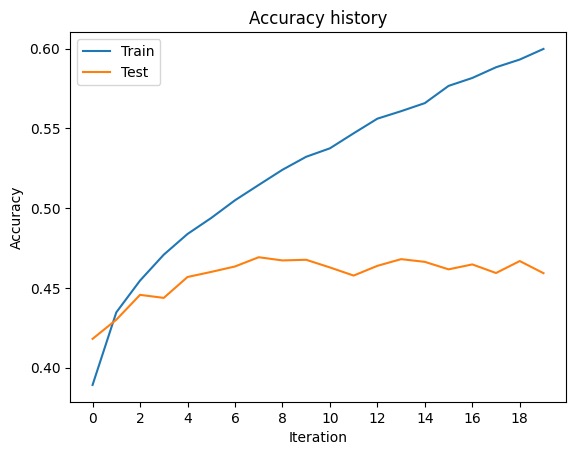

In [22]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

In [23]:
def calculate_accuracy(model: nn.Module, dataloader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            x, y = inputs.to(device), labels.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total

In [24]:
train_accuracy = calculate_accuracy(model, trainloader)
test_accuracy = calculate_accuracy(model, testloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 62.28%
Test accuracy: 45.92%
